## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# to hide warnings or atleast some of them (caused by mapping with lambda)
import logging
logging.getLogger("tensorflow").disabled = True

## Prepare the dataset

In [2]:
# The split into "train" is not directly necessary 
# because there is only training data available
dataset, info = tfds.load("malaria", split = "train", as_supervised=True, with_info = True)

# but without the "split" we would have to call dataset["train"] 
# because it would be a dict
print(type(tfds.load("malaria")))

<class 'dict'>


In [3]:
# We want 80% of the dataset to be training data
train_count = int(len(dataset)*0.8)

# So we "take" 80%
train_dataset = dataset.take(train_count)

# and then "skip" 80% and take the remaining 20%
test_dataset = dataset.skip(train_count)

## Inspect the dataset

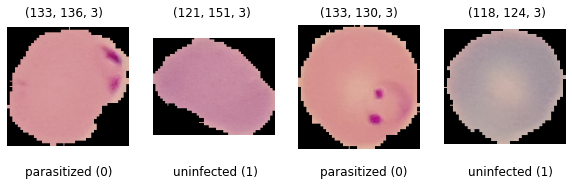

In [4]:
# shorter version, but without shape and unaligned text
# tfds.show_examples(dataset, info)

fig, ax = plt.subplots(1, 4, figsize=(10,10))
for index, (image, label) in enumerate(test_dataset.take(4)):
    ax[index].imshow(image)
    ax[index].axis('off')
    
    # add shape and label to the image
    fig.text(0.205*index+0.15,0.6, str(image.shape), size=12)
    if label.numpy() == 0:
        fig.text(0.205*index+0.15,0.38, "parasitized (0)", size=12)
    else:
        fig.text(0.205*index+0.15,0.38, "uninfected (1)", size=12)


## Fix the different shapes

In order to get all images in one uniform quadratic shape we have 3 options
*  Crop to quadratic
*  Resize, while perserving aspect ratio (pad with zeros)
*  Resize, but change aspect ratio

Because the import information of our images does not come from the black areas
we choose the **2nd** option.

This also makes sense with resepect to our filters because they are invariant to position, 
so it does not matter if there is first a balck area and then the cell or the other way around.
But the filters are not invariant to distortion which can happen in the 3rd option

In [5]:
# Before we can map our images to the target square 
# we have to find out the smalles shape value
min_shape = min([min(image.shape[0:2]) for (image, label) in dataset])
min_shape

40

In [6]:
# Now that we know the smalles shape value of all images
# we can resize and pad every image into a square of shape(40,40)
# Don't mind the potential warnings, all works fine

# To speed up the learning we catch the mapped data with .cache()
# so that the data does not have to be mapped every epoch
# memory wise this should be fine because we are not dealing with that much data

train_dataset = train_dataset.map(lambda image, label: (tf.image.resize_with_pad(image, min_shape, min_shape),label), num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

test_dataset = test_dataset.map(lambda image, label: (tf.image.resize_with_pad(image, min_shape, min_shape),label), num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Inspect the reshaped images

In [7]:
test_dataset_new_1 = test_dataset.map(lambda image, label: (tf.cast(image, tf.int32),label))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


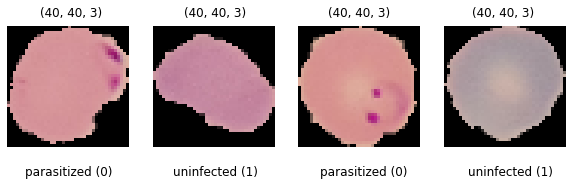

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(10,10))
for index, (image, label) in enumerate(test_dataset_new_1.take(4)):
    ax[index].imshow(image)
    ax[index].axis('off')
    
    # add shape and label to the image
    fig.text(0.20*index+0.17,0.6, str(image.shape), size=12)
    if label.numpy() == 0:
        fig.text(0.205*index+0.15,0.38, "parasitized (0)", size=12)
    else:
        fig.text(0.205*index+0.15,0.38, "uninfected (1)", size=12)

## Pipe the data

In [9]:
# encode the labels one-hot
# and again catch the mapped data
train_dataset = train_dataset.map(lambda image, label: (image, tf.one_hot(label, 2)), num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
test_dataset = test_dataset.map(lambda image, label: (image, tf.one_hot(label, 2)), num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()



# Create batches
train_dataset = train_dataset.batch(256)
test_dataset = test_dataset.batch(256)

# Prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [10]:
for (image, label) in train_dataset.take(1):
    print(image.shape)

(256, 40, 40, 3)


## Define the model

In [26]:
from tensorflow.keras import Model

class Model(Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv_1 = tf.keras.layers.Conv2D(filters = 64, 
                                             kernel_size = 3,
                                             activation = tf.keras.activations.relu,
                                             input_shape = (min_shape, min_shape, 3))
        
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        
        self.conv_2 = tf.keras.layers.Conv2D(filters = 128, 
                                             kernel_size = 3,
                                             activation = tf.keras.activations.relu)
        
        self.max_pool_2 = tf.keras.layers.MaxPool2D()
        
        self.conv_3 = tf.keras.layers.Conv2D(filters = 256, 
                                             kernel_size = 3,
                                             activation = tf.keras.activations.relu)
         
        self.max_pool_3 = tf.keras.layers.MaxPool2D()
        
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        
        self.output_layer = tf.keras.layers.Dense(units = 2, activation = tf.keras.activations.softmax)
        
        
    def call(self, x):
        
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.global_pool(x)
        x = self.output_layer(x)
        
        return x
        
    

## Define the training and test

In [27]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        accuracy = np.mean(np.argmax(target, axis=1) == np.argmax(prediction, axis=1))
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

def test(model, test_data, loss_function):
    # Test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

## Training the model

In [28]:
%%time
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.00001
running_average_factor = 0.95

model = Model()

# Initialize the loss
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

# Testing model performance on train and test data before learning
train_loss, train_accuracy = test(model, train_dataset, binary_cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

test_loss, test_accuracy = test(model, test_dataset, binary_cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Train loop for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    # Training
    running_average_loss = 0
    running_average_accuracy = 0
    for (input,target) in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, binary_cross_entropy_loss, optimizer)
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy
        
    train_losses.append(running_average_loss)
    train_accuracies.append(running_average_accuracy)

    # Testing
    test_loss, test_accuracy = test(model, test_dataset, binary_cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20
Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24
Epoch: __ 25
Epoch: __ 26
Epoch: __ 27
Epoch: __ 28
Epoch: __ 29
CPU times: user 2h 11min 25s, sys: 21min 49s, total: 2h 33min 15s
Wall time: 55min 33s


In [29]:
for (image, label) in train_dataset.take(2):
    a = image
    l = label

In [30]:
bce = tf.keras.losses.BinaryCrossentropy()
bce(label, model(a)).numpy()


0.39596713

## Plotting accuracy and loss for training and test data.


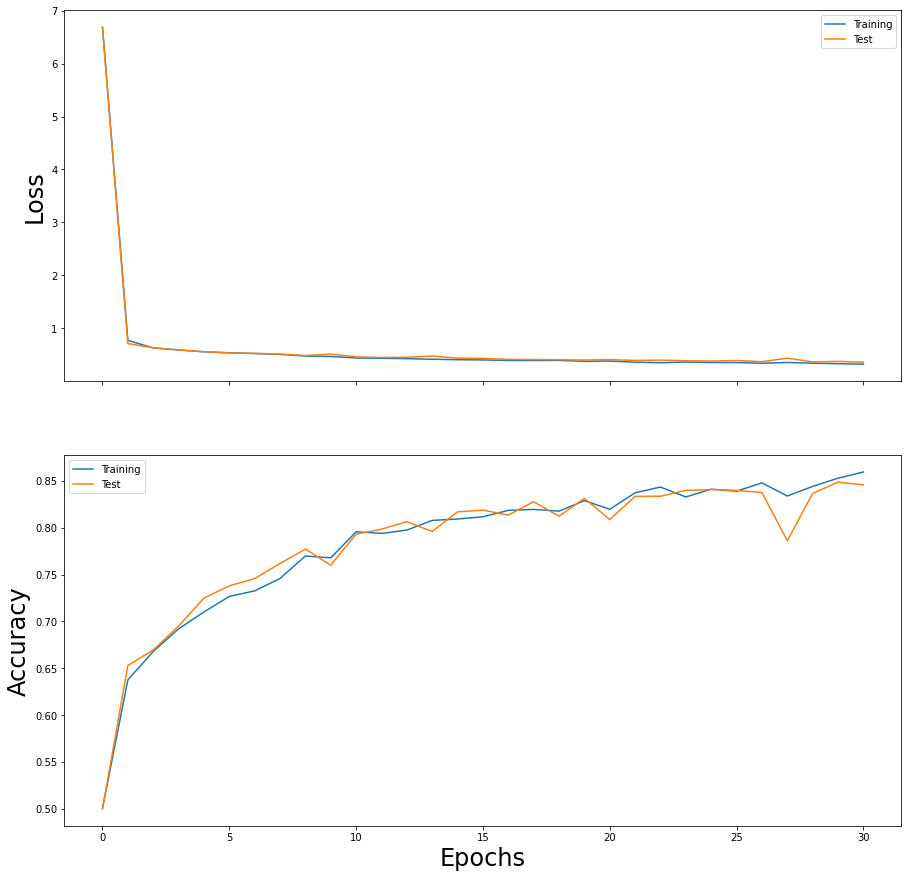

In [31]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,15))
ax[0].plot(train_losses,label="Training")
ax[0].plot(test_losses,label="Test")

ax[1].plot(train_accuracies,label="Training")
ax[1].plot(test_accuracies,label="Test")

fontsize=24
ax[0].set_ylabel("Loss",fontsize=fontsize)
ax[1].set_ylabel("Accuracy",fontsize=fontsize)
ax[1].set_xlabel("Epochs",fontsize=fontsize)
ax[0].legend()
ax[1].legend()
plt.show()